In [29]:
import torch
print(torch.cuda.is_available())

True


In [30]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

from utils import SOHTransformer, load_and_proc_data, monitor_idle_gpu_cpu, train_model, evaluate_model

# MONITORING =============================================================================================

import threading, subprocess, time, psutil

avg_time = 1
avg_power, avg_gpu_util, avg_cpu_util = monitor_idle_gpu_cpu(duration=avg_time)

print(f'\nAverage values over {avg_time} seconds: \nAVG_GPU_POWER = {avg_power}, AVG_GPU_UTIL = {avg_gpu_util}, AVG_CPU_UTIL = {avg_cpu_util}\n')

monitoring = True

def monitor_gpu(log_file = 'gpu_usage_log.csv', interval = 1):

    query_params = [
        "timestamp", "power.draw", "memory.used", "memory.total",
        "utilization.gpu", "utilization.memory", "temperature.gpu",
        "fan.speed", "clocks.sm", "clocks.gr"
    ]
    
    query_str = ",".join(query_params)
    
    with open(log_file, "w") as f:
        f.write("Timestamp,Power (W),Memory Used (MB),Memory Total (MB),GPU Util (%),"
                "Memory Util (%),Temp (C),Fan Speed (%),Clock SM (MHz),Clock Mem (MHz),"
                "CPU Usage (%)\n")
    
    while monitoring:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=" + query_str, "--format=csv,noheader,nounits"],
            capture_output=True, text=True
        )

        gpu_data = list(map(float, result.stdout.strip().split(", ")[1:]))
        gpu_data[0] = gpu_data[0] - avg_power
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
        cpu_usage = psutil.cpu_percent() - avg_cpu_util
        
        log_entry = f"{timestamp}," + ",".join(list(map(str, gpu_data))) + f",{cpu_usage}\n"
        
        with open(log_file, "a") as f:
            f.write(log_entry)

        time.sleep(interval)

# DATA PREPROC ===========================================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
directory = "data/battery/csv"
file_list = csv_files = [directory+'/'+f for f in os.listdir(directory) if f.endswith(".csv")]
targets = ['available_capacity (Ah)']
for f in file_list:
    print(f)

SEQ_LEN = 100
BATCH_SIZE = 32
features = ['pack_voltage (V)', 'charge_current (A)', 'max_temperature (℃)', 'min_temperature (℃)', 'soc', 'available_capacity (Ah)']
NUM_FEATURES = len(features)

_, _, train_loader, val_loader, test_loader, scaler_data = load_and_proc_data(file_list,
                                                                              features = features,
                                                                              targets=targets,
                                                                              SEQ_LEN = SEQ_LEN,
                                                                              BATCH_SIZE = BATCH_SIZE)



Average values over 1 seconds: 
AVG_GPU_POWER = 29.73, AVG_GPU_UTIL = 39.0, AVG_CPU_UTIL = 3.8

data/battery/csv/#4.csv
data/battery/csv/#13.csv
data/battery/csv/#10.csv
data/battery/csv/#12.csv
data/battery/csv/#15.csv
data/battery/csv/#3.csv
data/battery/csv/#18.csv
data/battery/csv/#17.csv
data/battery/csv/#8.csv
data/battery/csv/#16.csv
data/battery/csv/#5.csv
data/battery/csv/#11.csv
data/battery/csv/#1.csv
data/battery/csv/#19.csv
data/battery/csv/#6.csv
data/battery/csv/#7.csv
data/battery/csv/#20.csv
data/battery/csv/#2.csv
data/battery/csv/#14.csv
data/battery/csv/#9.csv


In [3]:
# MODELS - TRAINING ======================================================================================

model = SOHTransformer(input_dim=NUM_FEATURES, embed_dim=256).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_training_TRANSFORMER.csv', 1), daemon=True)
monitor_thread.start()

train_model(model, train_loader, val_loader, criterion, optimizer, "models/best_TRANSFORMER.pth", device, num_epochs=50)

monitoring = False

Epoch 1/50: Train Loss: 0.0185, Val Loss: 0.0243
Epoch 2/50: Train Loss: 0.0152, Val Loss: 0.0222
Epoch 3/50: Train Loss: 0.0143, Val Loss: 0.0209
Epoch 4/50: Train Loss: 0.0138, Val Loss: 0.0209
Epoch 5/50: Train Loss: 0.0137, Val Loss: 0.0195
Epoch 6/50: Train Loss: 0.0132, Val Loss: 0.0212
Epoch 7/50: Train Loss: 0.0129, Val Loss: 0.0192
Epoch 8/50: Train Loss: 0.0131, Val Loss: 0.0211
Epoch 9/50: Train Loss: 0.0130, Val Loss: 0.0209
Epoch 10/50: Train Loss: 0.0130, Val Loss: 0.0205
Epoch 11/50: Train Loss: 0.0124, Val Loss: 0.0209
Epoch 12/50: Train Loss: 0.0122, Val Loss: 0.0205
Epoch 13/50: Train Loss: 0.0125, Val Loss: 0.0207
Epoch 14/50: Train Loss: 0.0120, Val Loss: 0.0211
Epoch 15/50: Train Loss: 0.0119, Val Loss: 0.0212
Epoch 16/50: Train Loss: 0.0119, Val Loss: 0.0216
Epoch 17/50: Train Loss: 0.0122, Val Loss: 0.0204
Epoch 18/50: Train Loss: 0.0119, Val Loss: 0.0196
Epoch 19/50: Train Loss: 0.0119, Val Loss: 0.0195
Epoch 20/50: Train Loss: 0.0116, Val Loss: 0.0202
Epoch 21/


Test RMSE: 0.1321
Test MAE: 0.0712
Test R²: 0.6120
Test PCC: [0.98621356 0.9776475  0.9693318  0.9613638  0.953727   0.94613916
 0.93886876 0.9317082  0.9249345  0.9179954  0.9117449  0.90605426
 0.89990807 0.89362615 0.88814515 0.8825293  0.87699133 0.8729525
 0.8684362  0.86326724 0.8589253  0.85422635 0.85117984 0.84689295
 0.84375846 0.8410351  0.8365885  0.8344819  0.8301856  0.8293467
 0.82601887 0.8235276  0.8242722  0.8187331  0.8172325  0.8139639
 0.8123899  0.8117475  0.8109838  0.8064241  0.8068472  0.8018449
 0.80460155 0.79916954 0.7980709  0.79748666 0.7926754  0.7955728
 0.79270464 0.78844273 0.7878803  0.78532606 0.78457683 0.7817052
 0.7841939  0.7800405  0.7756755  0.77646524 0.77583396 0.77336276
 0.7703323  0.7652933  0.762281   0.7586654  0.7569365  0.7553542
 0.7520358  0.74816734 0.7438744  0.74043393 0.7322764  0.7325482
 0.7260565  0.72201127 0.713913   0.7141782  0.7096537  0.70203424
 0.69840854 0.6983899  0.689884   0.6885528  0.68683577 0.6798055
 0.672659

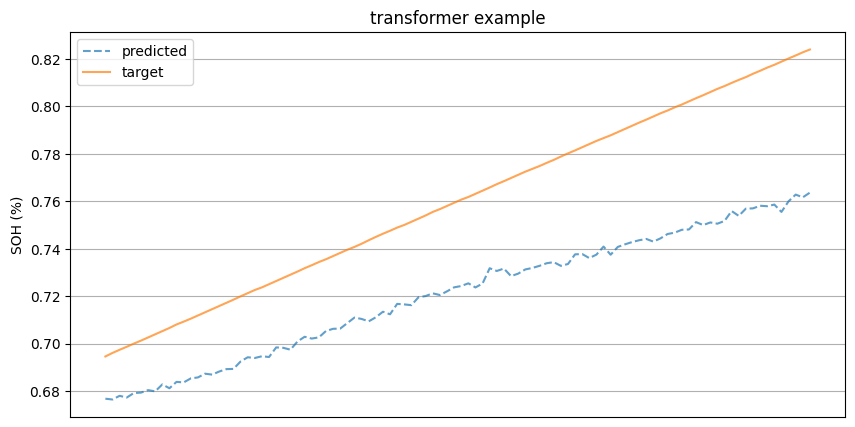

In [ ]:
# MODELS - TESTING =======================================================================================
from temp import evaluate_model
'''
model = SOHTransformer(input_dim=NUM_FEATURES, embed_dim=256).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
'''
monitoring = True
monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_TRANSFORMER.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
rmse, mae, r2, pcc, mda = evaluate_model(model, test_loader, "models/best_TRANSFORMER.pth", 'outputs/error_results_TRANSFORMER.txt', 'transformer', plot_fig = True, device=device, return_error_results=True)
print(f'{time.time()-start_time} seconds\n')

monitoring = False

### Model Processing

In [32]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

def evaluate_model(model, test_loader, output_save_file, plot_model_name='model', plot_fig = True, device=torch.device("cpu"), return_error_results = False, use_gpu = True):

    model.eval()

    first_test_flag = True

    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            if use_gpu:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
            else:
                outputs = model(batch_X)

            if first_test_flag and plot_fig:
                pred_out = outputs[0].cpu().numpy()
                target_out = batch_y[0].cpu().numpy()
                first_test_flag = False

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Compute error metrics
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    # Compute Pearson Correlation Coefficient (PCC)
    pcc, _ = pearsonr(all_targets, all_preds)

    # Compute Mean Directional Accuracy (MDA)
    direction_actual = np.sign(np.diff(all_targets))
    direction_pred = np.sign(np.diff(all_preds))

    mda = np.mean(direction_actual == direction_pred)

    print(f"\nTest RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Test PCC: {pcc}")
    print(f"Test MDA: {mda}")

    with open(output_save_file, "w") as f:
        f.write(f"Test RMSE: {rmse:.4f}\n")
        f.write(f"Test MAE: {mae:.4f}\n")
        f.write(f"Test R²: {r2:.4f}\n")
        f.write(f"Test PCC: {pcc}\n")
        f.write(f"Test MDA: {mda}\n")

    if plot_fig:
        plt.figure(figsize=(10, 5))
        plt.plot(pred_out, label="predicted", linestyle="dashed", alpha=0.7)
        plt.plot(target_out, label="target", linestyle="solid", alpha=0.7)
        
        plt.ylabel("SOH (%)")
        plt.xticks([])
        plt.title(f'{plot_model_name} example')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'outputs/figures/{plot_model_name}_example.png')

    if return_error_results:
        return rmse, mae, r2, pcc, mda

#### Pruning


Test RMSE: 0.1324
Test MAE: 0.0717
Test R²: 0.6104
Test PCC: [0.98602957 0.9775367  0.96920246 0.96123505 0.95358056 0.9459684
 0.93866044 0.9314457  0.9246286  0.917609   0.9113087  0.9053604
 0.899744   0.89306927 0.8876381  0.88218284 0.8765382  0.8723563
 0.8682626  0.8625236  0.858451   0.8537565  0.8503516  0.84607196
 0.843323   0.84038305 0.8363756  0.8339401  0.8297362  0.8289901
 0.8249749  0.82315344 0.8235902  0.8184193  0.8167146  0.81337774
 0.81148136 0.8112099  0.8103856  0.80540186 0.8061918  0.80307716
 0.80394065 0.79962856 0.7968213  0.7968596  0.79192466 0.7917998
 0.7916176  0.78751    0.7849639  0.7840324  0.7836648  0.77823
 0.78246355 0.77886087 0.77400696 0.7760117  0.77264285 0.7720447
 0.7690321  0.7645617  0.76021606 0.7562575  0.7559878  0.753518
 0.7501161  0.74592924 0.74280614 0.73895496 0.73023295 0.7322448
 0.7257474  0.72010386 0.7136716  0.71471876 0.70621735 0.7016509
 0.6972041  0.6975801  0.68796957 0.68967086 0.6839203  0.67612
 0.6707444  0.67

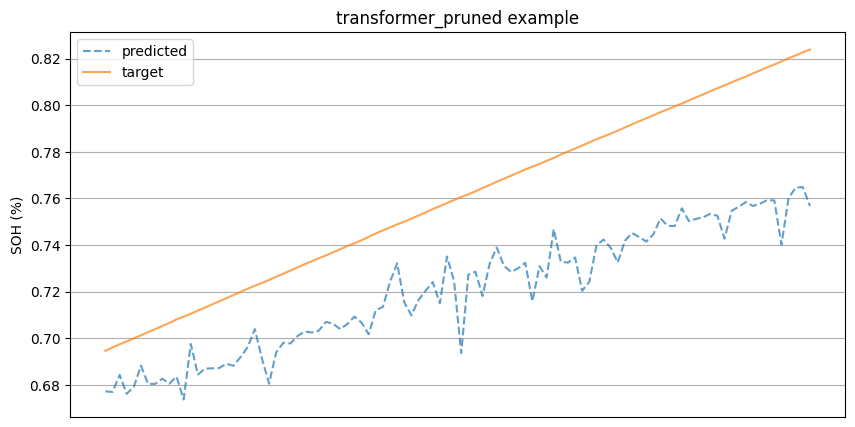

In [33]:
import torch.nn.utils.prune as prune

def apply_pruning(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

model_pruned = copy.deepcopy(model)
model_pruned = apply_pruning(model_pruned, amount=0.1)

rmse_p, mae_p, r2_p, pcc_p, mda_p = evaluate_model(model_pruned, test_loader, 'outputs/error_results_TRANSFORMER_pruned.txt', 'transformer_pruned', plot_fig = True, device=device, return_error_results=True)

#### Distillation


Test RMSE: 0.1545
Test MAE: 0.0871
Test R²: 0.4699
Test PCC: [0.9836163  0.97156435 0.96483123 0.9559558  0.9445387  0.9385501
 0.93171936 0.9207128  0.9152523  0.9079826  0.90129715 0.8917364
 0.8772884  0.87426466 0.8683733  0.864479   0.84700006 0.84041256
 0.8300854  0.81793475 0.8097281  0.8013927  0.7990465  0.8101048
 0.78082824 0.7831335  0.7868003  0.78520685 0.7672213  0.7558602
 0.75819516 0.7568331  0.7471733  0.73284227 0.7011316  0.72814494
 0.71160877 0.7254438  0.70941323 0.6642542  0.68699074 0.6837594
 0.6895691  0.68892753 0.65253466 0.66714615 0.6637638  0.65834403
 0.66276395 0.6404076  0.6548669  0.63381183 0.64877015 0.65218425
 0.64602715 0.6579291  0.6362526  0.62952834 0.63009286 0.6051054
 0.6094756  0.6127012  0.59981924 0.6130455  0.6094452  0.6263996
 0.59752613 0.5971712  0.6115896  0.5854558  0.5498017  0.58374065
 0.56114763 0.5736885  0.5589457  0.56736416 0.5604008  0.568872
 0.5616343  0.5669629  0.5585158  0.55718714 0.5594564  0.5426339
 0.5408450

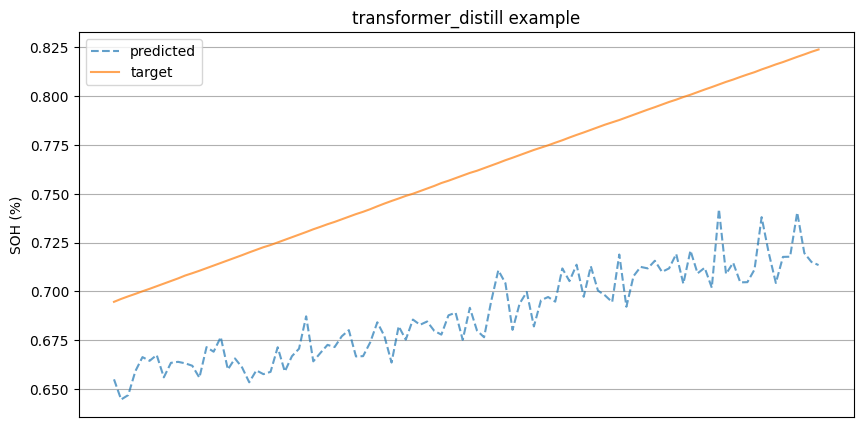

In [34]:
def train_student_model(teacher_model, student_model, train_loader, criterion, criterion_kd, optimizer, alpha=0.5, T=3.0):
    teacher_model.eval()
    student_model.train()

    device = next(teacher_model.parameters()).device  # Get model device
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move inputs to the same device as model

        optimizer.zero_grad()

        with torch.no_grad():
            soft_targets = torch.softmax(teacher_model(batch_X) / T, dim=1)  # Ensure input is on the same device

        student_output = student_model(batch_X)  # Ensure input is on the same device
        loss_hard = criterion(student_output, batch_y)
        loss_soft = criterion_kd(torch.log_softmax(student_output / T, dim=1), soft_targets)

        loss = alpha * loss_hard + (1 - alpha) * loss_soft
        loss.backward()
        optimizer.step()

    return student_model

student_model = SOHTransformer(input_dim=NUM_FEATURES, embed_dim=128).to(device)
criterion = nn.MSELoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.AdamW(student_model.parameters(), lr=5e-5, weight_decay=1e-4)
student_model = train_student_model(model, student_model, train_loader, criterion, criterion_kd, optimizer)

rmse_d, mae_d, r2_d, pcc_d, mda_d = evaluate_model(student_model, test_loader, 'outputs/error_results_TRANSFORMER_distill.txt', 'transformer_distill', plot_fig = True, device=device, return_error_results=True)

#### Quantization

In [35]:
def apply_quantization(model):
    model.cpu()  # Move model to CPU since dynamic quantization only works on CPU
    quantized_model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )
    return quantized_model

model_quantized = copy.deepcopy(model)
model_quantized = apply_quantization(model_quantized)
rmse_q, mae_q, r2_q, pcc_q, mda_q = evaluate_model(model_quantized, test_loader, 'outputs/error_results_TRANSFORMER_quantized.txt', 'transformer_quantized', plot_fig = True, use_gpu=False, return_error_results=True)

AttributeError: 'function' object has no attribute 'device'

## Results

transformer_base
transformer_pruned
transformer_distill


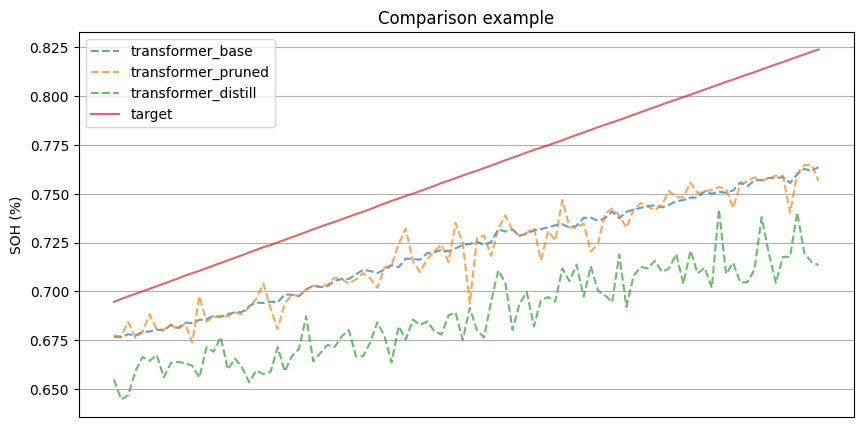

In [36]:
def evaluate_all_models(models, test_loader, use_gpus, model_names, plot_name='Comparison', plot_fig = True, device=torch.device("cpu"), return_error_results = False):

    preds = []

    for model, use_gpu, model_name in zip(models, use_gpus, model_names):

        model.eval()
        print(model_name)

        first_test_flag = True

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                if use_gpu:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)

                if first_test_flag and plot_fig:
                    pred_out = outputs[0].cpu().numpy()
                    preds.append(pred_out)
                    target_out = batch_y[0].cpu().numpy()
                    first_test_flag = False

    if plot_fig:
        plt.figure(figsize=(10, 5))
        for pred, model_name in zip(preds, model_names):
            plt.plot(pred, label=model_name, linestyle="dashed", alpha=0.7)
        plt.plot(target_out, label="target", linestyle="solid", alpha=0.7)
        
        plt.ylabel("SOH (%)")
        plt.xticks([])
        plt.title(f'{plot_name} example')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'outputs/figures/transformer_{plot_name.lower()}.png')

evaluate_all_models([model, model_pruned, student_model], test_loader,
                    [True, True, True], 
                    ['transformer_base', 'transformer_pruned', 'transformer_distill'],
                    plot_fig = True, device=device)

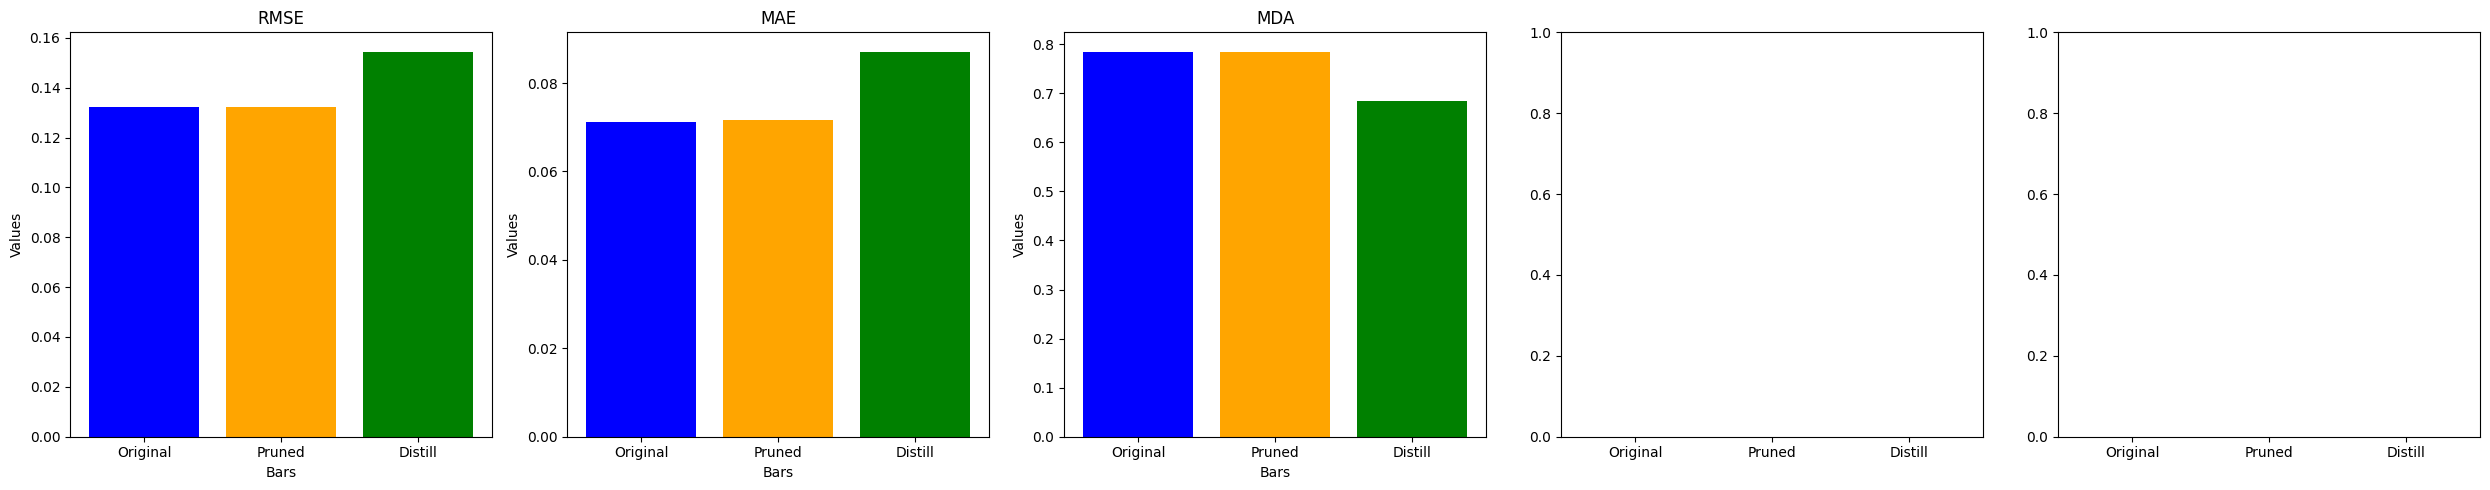

In [40]:
import matplotlib.pyplot as plt
'''
values = np.array([[rmse, rmse_p, rmse_d, rmse_q],
                   [mae , mae_p , mae_d , mae_q],
                   [r2  , r2_p  , r2_d  , r2_q],
                   [pcc  , pcc_p  , pcc_d  , pcc_q],
                   [mda  , mda_p  , mda_d  , mda_q]])
'''
values = np.array([[rmse, rmse_p, rmse_d],
                   [mae , mae_p , mae_d],
                   [r2  , r2_p  , r2_d],
                   [pcc.mean()  , pcc_p.mean()  , pcc_d.mean()],
                   [mda  , mda_p  , mda_d]])

#bar_labels = ['Original', 'Pruned', 'Distill', 'Quantized']

bar_labels = ['Original', 'Pruned', 'Distill']

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)

# RMSE Plot
ax_rmse = axes[0]
ax_rmse.bar(bar_labels, values[0], color=['blue', 'orange', 'green', 'red'])
ax_rmse.set_title("RMSE")
ax_rmse.set_ylabel("Values")
ax_rmse.set_xlabel("Bars")

# MAE Plot
ax_mae = axes[1]
ax_mae.bar(bar_labels, values[1], color=['blue', 'orange', 'green', 'red'])
ax_mae.set_title("MAE")
ax_mae.set_ylabel("Values")
ax_mae.set_xlabel("Bars")

# R2 Plot
ax_r2 = axes[2]
ax_r2.bar(bar_labels, values[2], color=['blue', 'orange', 'green', 'red'])
ax_r2.set_title("R²")
ax_r2.set_ylabel("Values")
ax_r2.set_xlabel("Bars")

# PCC Plot
ax_pcc = axes[2]
ax_pcc.bar(bar_labels, values[3], color=['blue', 'orange', 'green', 'red'])
ax_pcc.set_title("PCC")
ax_pcc.set_ylabel("Values")
ax_pcc.set_xlabel("Bars")

# MDA Plot
ax_mda = axes[2]
ax_mda.bar(bar_labels, values[4], color=['blue', 'orange', 'green', 'red'])
ax_mda.set_title("MDA")
ax_mda.set_ylabel("Values")
ax_mda.set_xlabel("Bars")

# Adjust layout and display
plt.tight_layout()
plt.show()


#### Monitoring

In [ ]:
import subprocess, threading, time, psutil

monitoring = True

def monitor_idle_gpu_cpu(duration=10, interval=1):
    
    power_values = []
    gpu_util_values = []
    cpu_util_values = []
    memory_used_values = []
    
    start_time = time.time()
    
    while time.time() - start_time < duration:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=power.draw,utilization.gpu,memory.used", "--format=csv,noheader,nounits"],
            capture_output=True, text=True
        )
        
        power, gpu_util, memory_used = map(float, result.stdout.strip().split(", "))
        cpu_util = psutil.cpu_percent(interval=0.1)
        
        power_values.append(power)
        gpu_util_values.append(gpu_util)
        cpu_util_values.append(cpu_util)
        memory_used_values.append(memory_used)
        
        time.sleep(interval)
    
    avg_power = sum(power_values) / len(power_values)
    avg_gpu_util = sum(gpu_util_values) / len(gpu_util_values)
    avg_cpu_util = sum(cpu_util_values) / len(cpu_util_values)
    memory_used_max = max(memory_used_values)
    
    return avg_power, avg_gpu_util, avg_cpu_util, memory_used_max

def monitor_gpu(log_file = 'gpu_usage_log.csv', interval = 1):

    query_params = [
        "timestamp", "power.draw", "memory.used", "memory.total",
        "utilization.gpu", "utilization.memory", "temperature.gpu",
        "fan.speed", "clocks.sm", "clocks.gr"
    ]
    
    query_str = ",".join(query_params)
    
    with open(log_file, "w") as f:
        f.write("Timestamp,Power (W),Memory Used (MB),Memory Total (MB),GPU Util (%),"
                "Memory Util (%),Temp (C),Fan Speed (%),Clock SM (MHz),Clock Mem (MHz),"
                "CPU Usage (%)\n")
    
    while monitoring:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=" + query_str, "--format=csv,noheader,nounits"],
            capture_output=True, text=True
        )

        gpu_data = list(map(float, result.stdout.strip().split(", ")[1:]))
        gpu_data[0] = gpu_data[0] - avg_power
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
        cpu_usage = psutil.cpu_percent() - avg_cpu_util
        
        log_entry = f"{timestamp}," + ",".join(list(map(str, gpu_data))) + f",{cpu_usage}\n"
        
        with open(log_file, "a") as f:
            f.write(log_entry)

        time.sleep(interval)

In [ ]:
avg_time = 10
avg_power, avg_gpu_util, avg_cpu_util, memory_used_max = monitor_idle_gpu_cpu(duration=avg_time)

print(f'\nAverage values over {avg_time} seconds: \nAVG_GPU_POWER = {avg_power}, AVG_GPU_UTIL = {avg_gpu_util}, AVG_CPU_UTIL = {avg_cpu_util}, MAX_MEMORY_UTIL = {memory_used_max}\n')

def evaluate_model_monitor(model, test_loader, use_gpu=True):
    
    model.eval()

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            if use_gpu:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()

# Original ===============================================================================================

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_original.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
evaluate_model_monitor(model, test_loader)
print(f'Original : {time.time()-start_time} seconds\n')

monitoring = False
time.sleep(2)
monitoring = True

# Pruned =================================================================================================

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_pruned.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
evaluate_model_monitor(model_pruned, test_loader)
print(f'Pruned : {time.time()-start_time} seconds\n')

monitoring = False
time.sleep(2)
monitoring = True

# Distill ================================================================================================

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_distill.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
evaluate_model_monitor(student_model, test_loader)
print(f'Distill : {time.time()-start_time} seconds\n')

monitoring = False
time.sleep(2)
monitoring = True

# Quantized ==============================================================================================

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_quantized.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
evaluate_model_monitor(model_quantized, test_loader, use_gpu=False)
print(f'Quantized : {time.time()-start_time} seconds\n')

monitoring = False
time.sleep(2)
monitoring = True

In [ ]:
'''
def save_test_data(test_loader):
    X_test, y_test = [], []
    for batch_X, batch_y in test_loader:
        X_test.append(batch_X)
        y_test.append(batch_y)
    
    X_test = torch.cat(X_test)
    y_test = torch.cat(y_test)
    torch.save({"X": X_test, "y": y_test}, "test_data/test_data.pt")

# Save model
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(model_quantized, "models/quantized_soh_tec_model.pth")
#save_test_data(test_loader)'
'''